In [95]:
%reload_ext autoreload
%autoreload 2

In [96]:
import numpy as np

import torch
import torch.optim as optim

import matplotlib.pyplot as plt
import time

from core import NormalizingFlow

In [97]:
# checking my implementation
flow = NormalizingFlow(D=2, K=100)
torch.manual_seed(42)
_, log_prob_1 = flow.sample(n=100, efficient=True)
torch.manual_seed(42)
_, log_prob_2 = flow.sample(n=100, efficient=False)  # using torch's jacobian function underneath
print(torch.allclose(log_prob_1, log_prob_2))

True


## Potential function

### My custom potential function

In [98]:
def U_with_argument(z, angle, distance):
    rotational_matrix = torch.Tensor([
        [torch.cos(torch.tensor(angle)), -torch.sin(torch.tensor(angle))],
        [torch.sin(torch.tensor(angle)), torch.cos(torch.tensor(angle))]
    ])
    z = (rotational_matrix @ z.T).T
    term1 = 0.5 * ((torch.sqrt(z[:,0] ** 2 + z[:,1] ** 2) - distance) / 0.4) ** 2
    term2 = torch.log(
        torch.exp(-0.5 * ((z[:,0] - distance) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + distance) / 0.6) ** 2) + 
        1e-5
    )
    return (term1 - term2)

In [99]:
def U_eight(z, divider=1):
    return U_with_argument(z, torch.pi/4, 3) + \
           U_with_argument(z, torch.pi / 2 + torch.pi/4, 3) + \
           U_with_argument(z, 0, 3) + \
           U_with_argument(z, torch.pi / 2, 3)

### Other potential functions from paper

In [100]:
def w1(z): return torch.sin(2 * torch.pi * z[:, 0] / 4)                 
def w2(z): return 3 * torch.exp(-0.5 * ((z[:, 0] - 1) / 0.5) ** 2)
def σ(x): return 1 / (1 + torch.exp(-x))
def w3(z): return 3 * σ((z[:, 0] - 1) / 0.3)

In [101]:
def taper(z):
    return torch.sigmoid(
        ( 5 - torch.linalg.vector_norm(z, dim=1, ord=np.inf) ) * 10
    )

In [102]:
def add_taper(potential):
    def new_potential(z):
        # so density is exp(-potential(z) + log(taper(z))) = exp(-potential(z)) * taper(z)
        return potential(z) - torch.log(taper(z))
    return new_potential

In [103]:
def U1(z):
    part_1 = (1/2) * ((torch.sqrt(z[:,0] ** 2 + z[:,1]**2) - 2) / 0.4) ** 2
    part_2 = torch.log(
        torch.exp(-0.5 * ((z[:,0] - 2) / 0.6) ** 2) + 
        torch.exp(-0.5 * ((z[:,0] + 2) / 0.6) ** 2)
    )
    return (part_1 - part_2)

In [104]:
@add_taper
def U2(z):
    return ((1/2) * ((z[:,1] - w1(z)) / 0.4) ** 2)

In [105]:
@add_taper
def U3(z):
    return - torch.log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.35) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w2(z)) / 0.35) ** 2)
    )

In [106]:
@add_taper
def U4(z):
    return - torch.log(
        torch.exp(-0.5 * ((z[:, 1] - w1(z)) / 0.34) ** 2) + 
        torch.exp(-0.5 * ((z[:, 1] - w1(z) + w3(z)) / 0.35) ** 2)
    )

## Choosing a potential function

In [117]:
potential = "U8"

if potential == "U1":
    U = U1
    num_epochs = 5000
elif potential == "U2":
    U = U2
    num_epochs = 5000
elif potential == "U3":
    U = U3
    num_epochs = 10000
elif potential == "U4":
    U = U4
    num_epochs = 10000
elif potential == "U8":
    U = U_eight
    num_epochs = 10000

## Graphing potential function

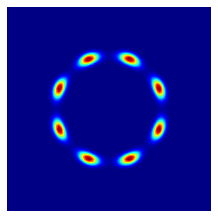

In [118]:
fig = plt.figure(figsize=(3.75, 3.75))

xs = torch.linspace(-6, 6, 100)
xxs, yys = torch.meshgrid(xs, xs)
xxs2, yys2 = xxs.reshape(-1, 1), yys.reshape(-1, 1)
unnorm_p = torch.exp(- U(torch.hstack([xxs2, yys2]))) #* decay(torch.hstack([xxs2, yys2]))

plt.contourf(xxs.numpy(), yys.numpy(), unnorm_p.reshape(100, 100).numpy(), levels=100, cmap="jet")
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')
plt.savefig(f"imgs/{potential}_true_density.png", dpi=300, bbox_inches='tight')

## Training

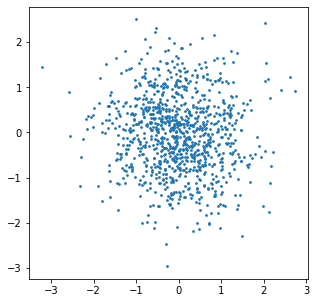

In [119]:
flow = NormalizingFlow(D=2, K=100)

with torch.no_grad():
    samples_untrained = flow.sample(n=1000, efficient=True)[0]
    
plt.figure(figsize=(5, 5))
plt.scatter(samples_untrained[:, 0], samples_untrained[:, 1], s=3)
plt.show()

In [120]:
flow = NormalizingFlow(D=2, K=50)
opt = optim.Adam(flow.parameters(), lr=2e-3)

start = time.perf_counter()

samples_kls = []

for i in range(1, num_epochs + 1):
    
    samples_from_q_K, log_probs = flow.sample(n=1000, efficient=True)
    sample_kl = (log_probs + U(samples_from_q_K)).mean()  # monte-carlo estimate of the kl-divergence
    samples_kls.append(float(sample_kl))
    
    opt.zero_grad()
    sample_kl.backward()
    opt.step()

    if i % 100 == 0:
        
        print(i, float(sample_kl))
            
end = time.perf_counter()
end - start

100 17.301164627075195
200 11.241275787353516
300 9.817535400390625
400 9.428613662719727
500 9.260852813720703
600 9.20004940032959
700 9.14075756072998
800 9.189620971679688
900 9.081009864807129
1000 9.05408763885498
1100 8.935919761657715
1200 8.967796325683594
1300 8.920601844787598
1400 8.9248046875
1500 8.840801239013672
1600 8.859511375427246
1700 8.772714614868164
1800 8.82956600189209
1900 8.788615226745605
2000 8.769635200500488
2100 8.7521390914917
2200 8.750155448913574
2300 8.744958877563477
2400 8.73791217803955
2500 8.74654769897461
2600 8.742505073547363
2700 8.68624496459961
2800 8.696025848388672
2900 8.64084243774414
3000 8.688146591186523
3100 8.623455047607422
3200 8.50572681427002
3300 8.427389144897461
3400 8.369173049926758
3500 8.274054527282715
3600 8.265789031982422
3700 8.22497844696045
3800 8.194694519042969
3900 8.228266716003418
4000 8.158912658691406
4100 8.113033294677734
4200 8.095905303955078
4300 8.078856468200684
4400 8.054007530212402
4500 8.10528

229.61198041599982

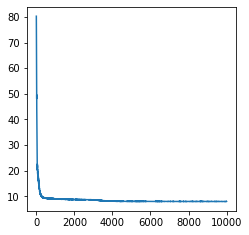

In [122]:
fig = plt.figure(figsize=(3.75, 3.75))
plt.plot(samples_kls)
plt.savefig(f"imgs/{potential}_kl_over_time.png", dpi=300, bbox_inches='tight')

## Graphing

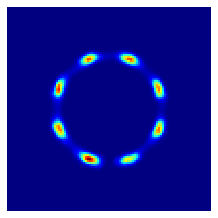

In [123]:
fig = plt.figure(figsize=(3.75, 3.75))

samples_qK, _ = flow.sample(n=int(1e6))
samples_qK = samples_qK.detach().numpy()

#samples_qK = samples_qK[np.bitwise_and(samples_qK[:,0] >= -4 , samples_qK[:,0] <= 4)]

# plt.hexbin(samples_qK[:,0], samples_qK[:,1], gridsize=50, cmap="turbo", extent=[-4, 4, -4, 4])
plt.hist2d(samples_qK[:,0], samples_qK[:,1], bins=100, cmap="jet", range=[[-6, 6], [-6, 6]])
    
plt.axis("off")
plt.gca().set_aspect('equal', adjustable='box')

plt.savefig(f"imgs/{potential}_learned_density.png", dpi=300, bbox_inches='tight')

In [124]:
n = 10000

In [125]:
# copied from stackoverflow
phi = np.linspace(0, 2*np.pi, n)
x = np.sin(phi)
y = np.cos(phi)
rgb_cycle = (np.stack((np.cos(phi          ), # Three sinusoids,
                       np.cos(phi+2*np.pi/3), # 120° phase shifted,
                       np.cos(phi-2*np.pi/3)
                      )).T # Shape = (60,3)
             + 1)*0.5   

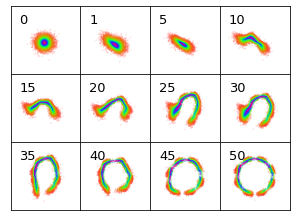

In [126]:
samples_from_each_layer = flow.sample_from_each_layer(n=n)
samples_from_each_layer = [samples.detach().numpy() for samples in samples_from_each_layer]

indices = np.argsort(
    (samples_from_each_layer[0][:,0] - float(flow.μ[0])) ** 2 + 
    (samples_from_each_layer[0][:,1] - float(flow.μ[1])) ** 2
)

fig = plt.figure(figsize=(5, 5 / 4 * 3), )
for i, j in enumerate([0, 1, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]):
    fig.add_subplot(3, 4, i+1)
    plt.scatter(samples_from_each_layer[j][:,0][indices], 
                samples_from_each_layer[j][:,1][indices], 
                color=rgb_cycle,
                s=0.01, alpha=1)
    plt.text(-4.5, 3, f"{j}", size=13)
    plt.xlim(-6, 6)
    plt.ylim(-6, 6)
    plt.xticks([])
    plt.yticks([])
fig.subplots_adjust(wspace=0, hspace=0)

plt.savefig(f"imgs/{potential}_samples_from_each_layer.png", dpi=300, bbox_inches='tight')

## Unused code

In [ ]:
# connecting lines between points in q0 and points in qk

# samples_q0, samples_qK, _ = flow.sample_and_return_log_prob(n=1000)
# samples_q0 = samples_q0.detach().numpy()
# samples_qK = samples_qK.detach().numpy()

# for i in range(len(samples_q0)):
#     plt.plot([samples_q0[i][0] + 5, samples_qK[i][0]], 
#              [samples_q0[i][1] + 5, samples_qK[i][1]], 
#              color="black", linewidth=0.2, alpha=0.1)

# plt.scatter(samples_q0[:,0] + 5, samples_q0[:,1] + 5, s=5, color="green", alpha=0.1)
# plt.scatter(samples_qK[:,0], samples_qK[:,1], s=5, color="red", alpha=0.1)
    
# #plt.xlim(-4, 4)
# #plt.ylim(-4, 4)
# plt.axis("off")
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig("flow.png", dpi=300)

In [ ]:
# density plot with Gaussian KDE

# _, samples_qK, _ = flow.sample_and_return_log_prob(n=100000)
# samples_qK = samples_qK.detach().numpy()

# x, y = samples_qK[:,0], samples_qK[:,1]
# nbins = 50
# xi, yi = np.meshgrid(np.linspace(x.min(), x.max(), nbins), np.linspace(y.min(), y.max(), nbins))

# k = kde.gaussian_kde(samples_qK.T, bw_method=0.02)
# zi = k(np.vstack([xi.flatten(), yi.flatten()]))

# plt.contourf(xi, yi, zi.reshape(xi.shape), levels=20, cmap="turbo")

# plt.xlim(-4, 4)
# plt.ylim(-4, 4)
# plt.axis("off")
# plt.gca().set_aspect('equal', adjustable='box')
# plt.savefig("u4_density_estimated.png", dpi=1000)